# Reinforcement Learning: Assignment 2  
**Modified Black Jack: A Cards Game**  
**Instructor**: Mudassar Liaq  
**Session**: Fall 2024  
**Deadline**: 11:50 PM on 16th November 2024  

---

## 1. Objective

The goal of this assignment is to apply reinforcement learning methods to a simple card game (similar to Blackjack). This exercise is inspired by the Blackjack example in Sutton and Barto, Section 5.3. However, note that the rules of this card game differ and are non-standard.

### Game Rules

- The game is played with an infinite deck of cards (cards are sampled with replacement).
- Each draw results in a value between 1 and 13 (uniformly distributed) with a color of red (probability 1/3) or black (probability 2/3).
- Face cards are assigned values as follows: Jack = 11, Queen = 12, King = 13.
- At the beginning, both the player and dealer draw one black card (fully observed).
  - Each turn, the player may either **stick** or **hit**.
  - If the player hits, they draw another card from the deck.
  - If the player sticks, they receive no further cards.
- The player’s card values are added (black cards) or subtracted (red cards).
- If the player’s sum exceeds 21 or drops below 1, they “go bust” and lose the game (reward: -1).
- If the player sticks, the dealer begins taking turns. The dealer always sticks on any sum of 17 or greater and hits otherwise.
  - If the dealer goes bust, the player wins.
  - If neither goes bust, the outcome (win, lose, or draw) is determined by the player and dealer’s final sums (reward: +1 for win, -1 for loss, 0 for draw).

---

## 2. Implementation

Write an environment to implement this game. Specifically, create a function `step` that:

- Takes as input a state \( s \) (dealer’s first card 1–13 and the player’s sum 1–21) and an action \( a \) (hit or stick).
- Returns a sample of the next state \( s' \) (which may be terminal if the game ends) and reward \( r \).
- The environment will be used for model-free reinforcement learning, without an explicit transition matrix for the MDP.
- No discounting is used (\( \gamma = 1 \)).
- Treat the dealer’s moves as part of the environment, i.e., calling `step` with a stick action will simulate the dealer’s play and return the final reward and terminal state.

### Monte Carlo Control

1. Apply Monte-Carlo control to this problem.
2. Initialize the value function to zero.
3. Use a time-varying scalar step-size of \( \alpha_t = \frac{1}{N(s_t, a_t)} \) and an \( \epsilon \)-greedy exploration strategy with \( \epsilon_t = \frac{N_0}{N_0 + N(s)} \), where \( N_0 = 100 \) is a constant, \( N(s) \) is the number of times state \( s \) has been visited, and \( N(s, a) \) is the number of times action \( a \) has been selected from state \( s \).
4. Feel free to adjust \( N_0 \) if it produces better results.
5. Plot the optimal value function \( V^*(s) = \max_a Q^*(s, a) \) using similar axes as in Figure 1 from Sutton and Barto’s Blackjack example.

### TD Learning

1. Implement Sarsa(λ).
2. Initialize the value function to zero.
3. Use the same step size and exploration schedules as in the previous section.
4. Run the algorithm with \( \lambda \in \{0, 0.1, 0.2, \dots, 1\} \).
5. Stop each run after 1000 episodes and report the mean-squared error \( \sum_{s,a}(Q(s, a) - Q^*(s, a))^2 \) over all states \( s \) and actions \( a \), comparing the true values \( Q^*(s, a) \) from Monte Carlo control with the estimated values \( Q(s, a) \) from Sarsa.
6. Plot the mean-squared error against \( \lambda \). For \( \lambda = 0 \) and \( \lambda = 1 \), plot the learning curve of mean-squared error against episode number.

---

## 3. Submission

- Submit a single PDF document containing your plots.
- Submit a single archive with all source code.
- Organize your code clearly, making it easy to understand and run.
- Complete the assignment in Jupyter notebooks. Any work done on Google Colab will receive **0 credit**.
- Use the forward view implementation of these algorithms. Implementations of the backward view (with eligibility traces) will result in **0 credits**.


## Group Members

- Submit a single PDF document containing your plots.
- Name:Kishan Dayanand Nishad ID : 200612579
- Name:Dacorie Smith ID: 200555201
- Samarat Chapagin ID:200549449


## Step 1: Define the Environment
- The game is played with an infinite deck of cards (cards are sampled with replacement).
- Each draw results in a value between 1 and 13 (uniformly distributed) with a color of red (probability 1/3) or black (probability 2/3).
- Face cards are assigned values as follows: Jack = 11, Queen = 12, King = 13.
- At the beginning, both the player and dealer draw one black card (fully observed).
  - Each turn, the player may either **stick** or **hit**.
  - If the player hits, they draw another card from the deck.
  - If the player sticks, they receive no further cards.
- The player’s card values are added (black cards) or subtracted (red cards).
- If the player’s sum exceeds 21 or drops below 1, they “go bust” and lose the game (reward: -1).
- If the player sticks, the dealer begins taking turns. The dealer always sticks on any sum of 17 or greater and hits otherwise.
  - If the dealer goes bust, the player wins.
  - If neither goes bust, the outcome (win, lose, or draw) is determined by the player and dealer’s final sums (reward: +1 for win, -1 for loss, 0 for draw).



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random

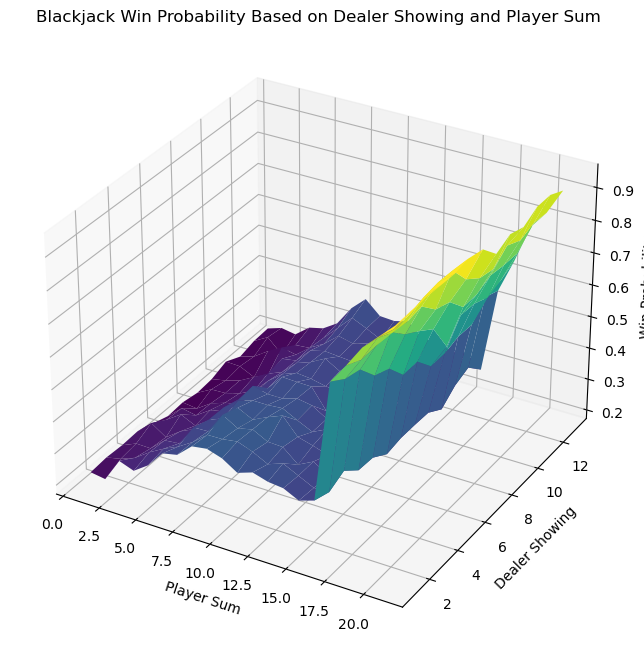

In [78]:
#Environment 
class BlackJackEnvironment :
    def __init__(self):
        self.reset()

    def reset(self):
        # Initialize player and dealer's first black card
        self.player_sum = 0
        self.player_sum = self.draw_card(black=True)
        self.dealer_card = self.draw_card(black=True)
        self.terminal = False
        return (self.dealer_card, self.player_sum)

    def draw_card(self, black=None):
        value = np.random.randint(1, 14)  # card values from 1 to 13
        color = 'black' if np.random.rand() < (2/3) else 'red'
        if black is not None:
            color = 'black' if black else 'red'
        return value if color == 'black' else -value

    def step(self,state, action):
        dealer_card, player_sum = state

        if action == "hit":
            card = self.draw_card()
            self.player_sum += card
            if self.player_sum < 1 or self.player_sum > 21:
                return (self.dealer_card, self.player_sum), -1, True
            return (self.dealer_card, self.player_sum), 0, False
        elif action == "stick":
            return self.play_dealer()
            
        return (dealer_card, player_sum), 0, False  # Continue game


    def play_dealer(self):
        dealer_sum = self.dealer_card
        while dealer_sum < 17:
            dealer_sum += self.draw_card()
            if dealer_sum < 1 or dealer_sum > 21:
                return (self.dealer_card, self.player_sum), 1, True
        if dealer_sum > self.player_sum:
            return (self.dealer_card, self.player_sum), -1, True
        elif dealer_sum < self.player_sum:
            return (self.dealer_card, self.player_sum), 1, True
        else:
            return (self.dealer_card, self.player_sum), 0, True

# Simulation function
def simulate_games(num_games):
    results = []
    env = BlackJackEnvironment()
    next_state = env.reset()
    
    for _ in range(num_games):
        env.reset()
        done = False
      
        while not done:
            # Simple strategy: hit until player_sum >= 17, otherwise stick
            action = "hit" if env.player_sum < 17 else "stick"
            next_state, reward, done = env.step(next_state,action)
        results.append(reward)
    
    return results
    
# Function to simulate games and calculate win rates
def calculate_win_probabilities(num_simulations=1000):
    win_counts = defaultdict(int)
    total_counts = defaultdict(int)

    # Iterate over all combinations of dealer showing and player sums
    for dealer_card in range(1, 14):
        for player_sum in range(1, 22):
            # Run multiple simulations for each (dealer_card, player_sum) pair
            for _ in range(num_simulations):
                env = BlackJackEnvironment()
                env.dealer_card = dealer_card
                env.player_sum = player_sum
                done = False
                state = (dealer_card, player_sum)

                # Simple strategy: stick if player_sum >= 17, else hit
                while not done:
                    action = "hit" if env.player_sum < 17 else "stick"
                    next_state, reward, done = env.step(state, action)
                    state = next_state

                # Record win (reward == 1), loss (reward == -1), and draws (reward == 0)
                if reward == 1:
                    win_counts[(dealer_card, player_sum)] += 1
                total_counts[(dealer_card, player_sum)] += 1

    # Calculate win probabilities for each (dealer_card, player_sum)
    win_probabilities = np.zeros((13, 21))
    for dealer_card in range(1, 14):
        for player_sum in range(1, 22):
            key = (dealer_card, player_sum)
            if total_counts[key] > 0:
                win_probabilities[dealer_card - 1, player_sum - 1] = win_counts[key] / total_counts[key]
    
    return win_probabilities

# Run the simulation to calculate win probabilities
num_simulations_per_state = 1000
win_probabilities = calculate_win_probabilities(num_simulations_per_state)

# Create 3D plot
dealer_showing = np.arange(1, 14)
player_sums = np.arange(1, 22)
X, Y = np.meshgrid(player_sums, dealer_showing)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, win_probabilities, cmap='viridis')

# Labels for the axes
ax.set_xlabel('Player Sum')
ax.set_ylabel('Dealer Showing')
ax.set_zlabel('Win Probability')
ax.set_title('Blackjack Win Probability Based on Dealer Showing and Player Sum')

plt.show()

Step 2: Monte Carlo Control
This code snippet uses the Monte Carlo method with an epsilon-greedy policy to approximate the optimal value function.

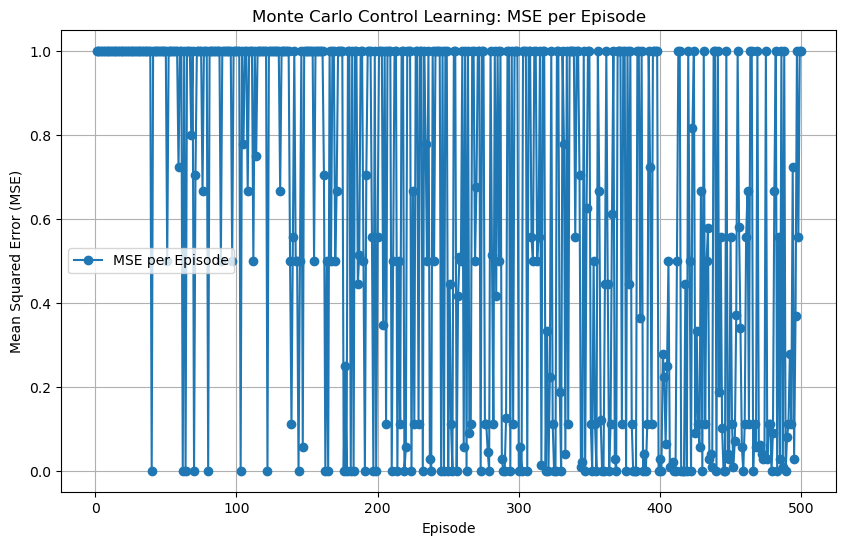

MSE Summary: {'Total Episodes': 500, 'Final MSE': 1.0, 'Average MSE': 0.6301293442932728}


In [76]:
import numpy as np
from collections import defaultdict
import random

def monte_carlo_control_forward_view_with_mse(env, num_episodes, epsilon=0.1, N0=100):
    # Initialize Q-value table with default values [0, 0] for actions 'hit' and 'stick'
    Q = defaultdict(lambda: [0, 0])
    
    # Initialize accumulators for the sum of returns and visit counts
    returns_sum = defaultdict(lambda: [0, 0])
    returns_count = defaultdict(lambda: [0, 0])
    
    # List to store MSE for each episode
    mse_per_episode = []

    # Loop through the specified number of episodes
    for episode in range(num_episodes):
        episode_data = []  # List to store state, action, and reward for the episode
        state = env.reset()  # Reset the environment to start a new episode
        done = False  # Flag to indicate if the episode is finished

        # Generate the episode by interacting with the environment
        while not done:
            # Calculate epsilon dynamically based on visit counts (exploration vs exploitation trade-off)
            epsilon = N0 / (N0 + sum(returns_count[state]))

            # Use epsilon-greedy policy to choose an action
            if random.random() < epsilon:  # Exploration: pick a random action
                action = random.choice(['hit', 'stick'])
            else:  # Exploitation: pick the action with the highest Q-value
                action = 'hit' if Q[state][0] > Q[state][1] else 'stick'

            # Take the chosen action and observe the next state, reward, and done flag
            next_state, reward, done = env.step(state, action)

            # Record the transition (state, action, reward) in the episode data
            episode_data.append((state, action, reward))

            # Move to the next state
            state = next_state

        # Initialize MSE for this episode
        episode_mse = 0
        num_updates = 0

        # Compute returns for each step in the episode (forward-view)
        for t, (state, action, _) in enumerate(episode_data):
            # Calculate the return (G) as the sum of rewards from time step t to the end of the episode
            G = sum(r for _, _, r in episode_data[t:])
            
            # Map the action ('hit' or 'stick') to its index in the Q-value table
            action_index = 0 if action == 'hit' else 1
            
            # Save the old Q-value for MSE calculation
            old_q_value = Q[state][action_index]
            
            # Update the total returns and visit counts for the state-action pair
            returns_sum[state][action_index] += G
            returns_count[state][action_index] += 1
            
            # Update the Q-value as the average return for the state-action pair
            Q[state][action_index] = returns_sum[state][action_index] / returns_count[state][action_index]

            # Update MSE for this episode
            episode_mse += (Q[state][action_index] - old_q_value) ** 2
            num_updates += 1

        # Normalize MSE for this episode
        mse_per_episode.append(episode_mse / num_updates if num_updates > 0 else 0)

    # Return the learned Q-value table and the MSE per episode
    return Q, mse_per_episode


# Run the Monte Carlo Control with MSE tracking
num_episodes = 500
env = BlackJackEnvironment()
Q, mse_per_episode = monte_carlo_control_forward_view_with_mse(env, num_episodes)

# Plot MSE over episodes
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_per_episode) + 1), mse_per_episode, marker='o', label='MSE per Episode')
plt.xlabel("Episode")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Monte Carlo Control Learning: MSE per Episode")
plt.grid()
plt.legend()
plt.show()

# Summary of results
mse_summary = {
    "Total Episodes": num_episodes,
    "Final MSE": mse_per_episode[-1],
    "Average MSE": np.mean(mse_per_episode)
}
print("MSE Summary:", mse_summary)

Step 3: Temporal-Difference (TD) Learning with Sarsa(λ)
Here's the implementation for Sarsa(λ) with a forward view.



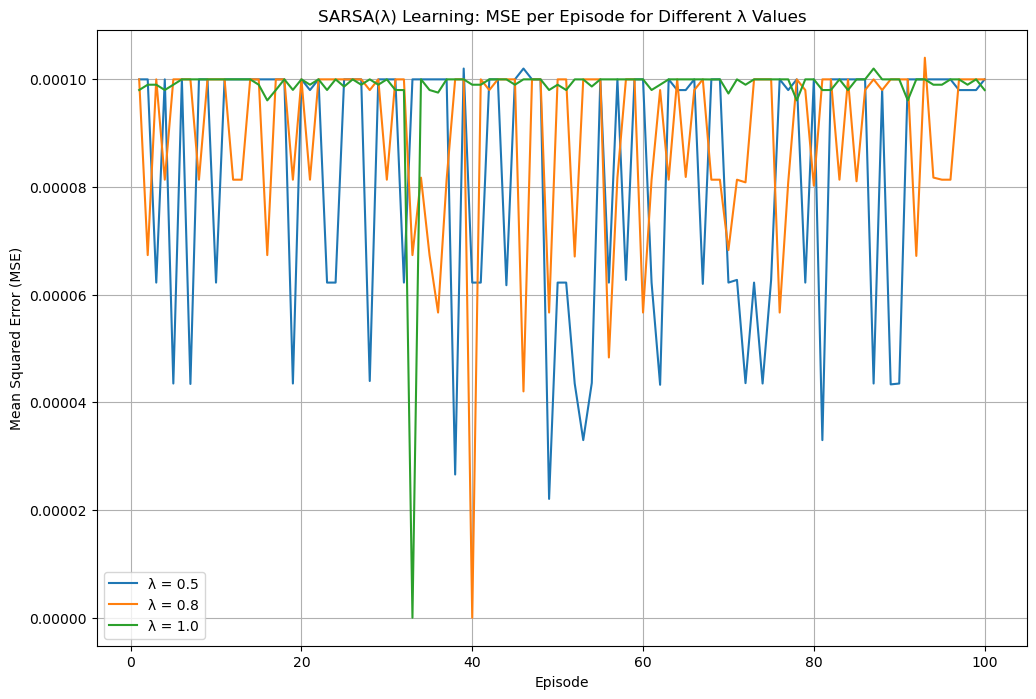

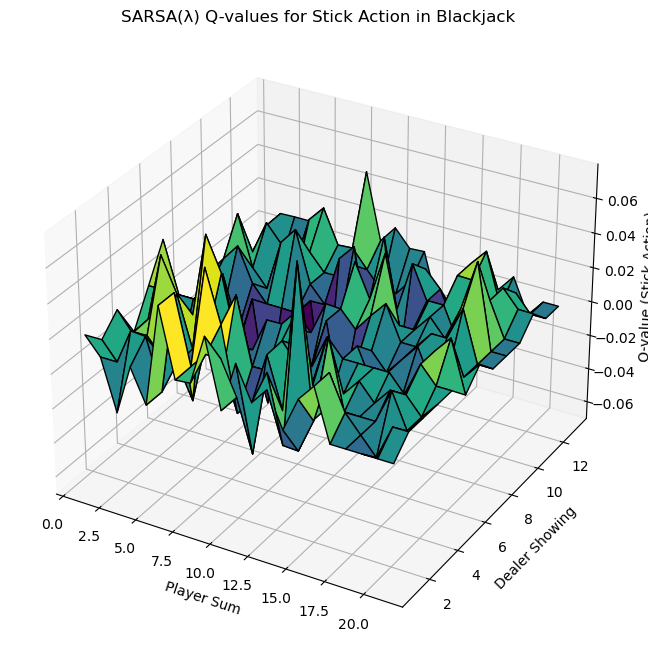

In [86]:
from collections import defaultdict
import numpy as np
import random
import matplotlib.pyplot as plt

# SARSA(λ) Forward View Algorithm with MSE tracking
def sarsa_lambda_forward(env, num_episodes, lam, alpha=0.01, gamma=0.99, N0=100):
    Q = defaultdict(lambda: [0, 0])  # Initialize Q-values for actions [hit, stick]
    mse_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False

        # Epsilon-greedy policy
        epsilon = N0 / (N0 + sum(Q[state]))  # Decaying epsilon based on Q-values
        action = random.choice(['hit', 'stick']) if random.random() < epsilon else 'hit' if Q[state][0] > Q[state][1] else 'stick'

        # Track the episode history of state-action pairs and rewards
        episode_data = []
        q_updates = []

        while not done:
            next_state, reward, done = env.step(state, action)
            next_epsilon = N0 / (N0 + sum(Q[next_state]))
            next_action = (
                random.choice(['hit', 'stick']) if random.random() < next_epsilon
                else 'hit' if Q[next_state][0] > Q[next_state][1] else 'stick'
            )

            # Store the current state, action, and reward for this step
            episode_data.append((state, action, reward))
            state = next_state
            action = next_action

        # Forward View Update after the episode is complete
        for t in range(len(episode_data)):
            state_t, action_t, reward_t = episode_data[t]
            action_index_t = 0 if action_t == 'hit' else 1

            # Calculate the cumulative return G from this step onward
            G = 0
            gamma_lambda = 1
            for k in range(t, len(episode_data)):
                _, _, reward_k = episode_data[k]
                G += gamma_lambda * reward_k
                gamma_lambda *= gamma * lam

                if k < len(episode_data) - 1:
                    next_state_k, next_action_k, _ = episode_data[k + 1]
                    next_action_index_k = 0 if next_action_k == 'hit' else 1
                    G += gamma_lambda * Q[next_state_k][next_action_index_k]

            old_q_value = Q[state_t][action_index_t]
            Q[state_t][action_index_t] += alpha * (G - Q[state_t][action_index_t])
            q_updates.append((old_q_value, Q[state_t][action_index_t]))

        # Calculate MSE based on Q-value updates
        mse = sum((new_q - old_q)**2 for old_q, new_q in q_updates) / len(q_updates) if q_updates else 0
        mse_per_episode.append(mse)

    return Q, mse_per_episode

# Run SARSA(λ) for the BlackJack environment
num_episodes = 100
lambdas = [0.5, 0.8, 1.0]
mse_values_sarsa = []

env = BlackJackEnvironment()  # Initialize your BlackJack environment here
for lam in lambdas:
    Q_sarsa, mse_per_episode = sarsa_lambda_forward(env, num_episodes, lam)
    mse_values_sarsa.append(mse_per_episode)

# Plot MSE per episode for different lambda values
plt.figure(figsize=(12, 8))
for lam, mse_per_episode in zip(lambdas, mse_values_sarsa):
    plt.plot(range(1, len(mse_per_episode) + 1), mse_per_episode, label=f"λ = {lam}")

plt.xlabel("Episode")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("SARSA(λ) Learning: MSE per Episode for Different λ Values")
plt.legend()
plt.grid()
plt.show()


# Initialize the BlackJackEnvironment class as per your setup
env = BlackJackEnvironment()  # Replace with your Blackjack environment setup

# Run SARSA(λ) for the BlackJack environment with lambda = 1.0
num_episodes = 1000
lambda_value = 1.0
Q_sarsa, _ = sarsa_lambda_forward(env, num_episodes, lambda_value)

# Prepare data for 3D plotting of Q-values for the "stick" action
dealer_showing = np.arange(1, 14)  # Dealer's possible showing cards (1 to 13)
player_sums = np.arange(1, 22)     # Player's possible sums (1 to 21)
win_probabilities = np.zeros((len(dealer_showing), len(player_sums)))

# Populate win_probabilities with Q values for the "stick" action
for i, dealer in enumerate(dealer_showing):
    for j, player_sum in enumerate(player_sums):
        state = (dealer, player_sum)
        if state in Q_sarsa:
            win_probabilities[i, j] = Q_sarsa[state][1]  # Q-value for 'stick' action

# Create a meshgrid for plotting
X, Y = np.meshgrid(player_sums, dealer_showing)

# 3D surface plot of Q-values for "stick" action
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, win_probabilities, cmap='viridis', edgecolor='k')

# Add labels and title
ax.set_xlabel('Player Sum')
ax.set_ylabel('Dealer Showing')
ax.set_zlabel('Q-value (Stick Action)')
ax.set_title('SARSA(λ) Q-values for Stick Action in Blackjack')

plt.show()

Step 4: Plotting
Now we can plot the mean-squared error for different values of λ and learning curves.  Finally, you can initialize the environment, run both Monte Carlo and Sarsa(λ) algorithms, and plot the results.

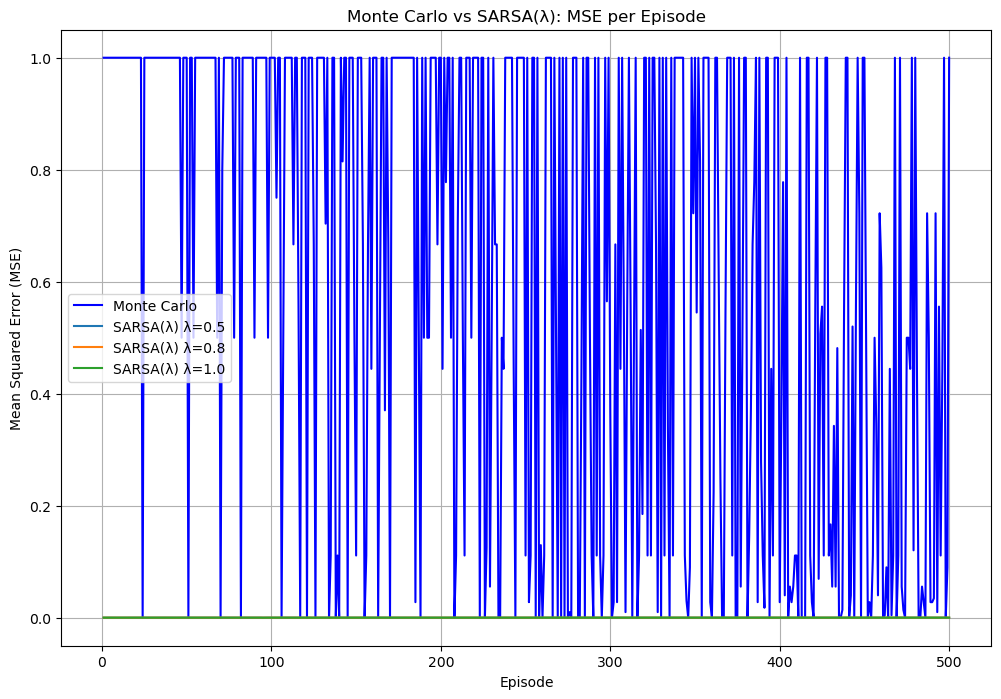

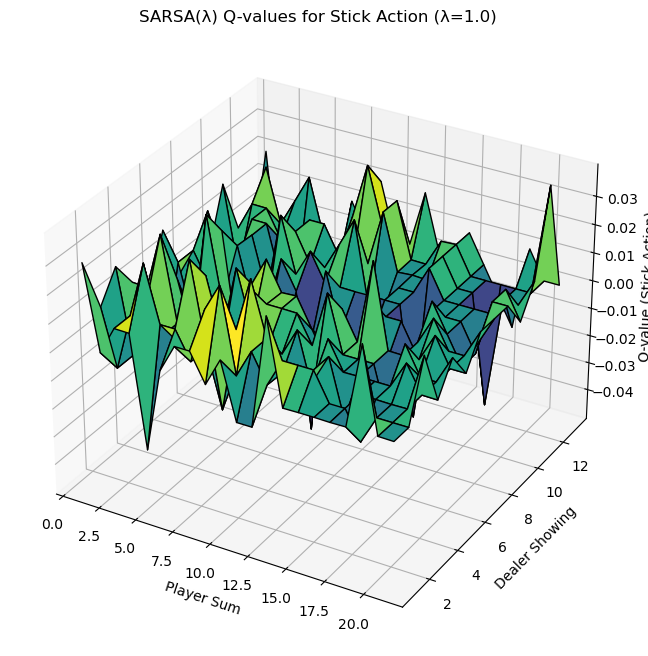

In [92]:

# Initialize the environment (assume BlackJackEnvironment is defined)
env = BlackJackEnvironment()

# Run Monte Carlo Control
num_episodes_mc = 500
Q_mc, mse_mc = monte_carlo_control_forward_view_with_mse(env, num_episodes_mc)

# Run SARSA(λ) for different λ values
num_episodes_sarsa = 500
lambdas = [0.5, 0.8, 1.0]
sarsa_results = {}
for lam in lambdas:
    Q_sarsa, mse_sarsa = sarsa_lambda_forward(env, num_episodes_sarsa, lam)
    sarsa_results[lam] = mse_sarsa

# Plot MSE for Monte Carlo and SARSA(λ)
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(mse_mc) + 1), mse_mc, label='Monte Carlo', color='blue')
for lam, mse_sarsa in sarsa_results.items():
    plt.plot(range(1, len(mse_sarsa) + 1), mse_sarsa, label=f'SARSA(λ) λ={lam}')
plt.xlabel("Episode")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Monte Carlo vs SARSA(λ): MSE per Episode")
plt.legend()
plt.grid()
plt.show()

# 3D Plot of SARSA(λ) Q-values for Stick Action
lambda_to_plot = 1.0  # Example: plot SARSA(λ) Q-values for λ = 1.0
Q_sarsa = defaultdict(lambda: [0, 0]) if lambda_to_plot not in sarsa_results else Q_sarsa
dealer_showing = np.arange(1, 14)
player_sums = np.arange(1, 22)
win_probabilities = np.zeros((len(dealer_showing), len(player_sums)))
for i, dealer in enumerate(dealer_showing):
    for j, player_sum in enumerate(player_sums):
        state = (dealer, player_sum)
        if state in Q_sarsa:
            win_probabilities[i, j] = Q_sarsa[state][1]

X, Y = np.meshgrid(player_sums, dealer_showing)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, win_probabilities, cmap='viridis', edgecolor='k')
ax.set_xlabel('Player Sum')
ax.set_ylabel('Dealer Showing')
ax.set_zlabel('Q-value (Stick Action)')
ax.set_title(f'SARSA(λ) Q-values for Stick Action (λ={lambda_to_plot})')
plt.show()

## Discussion 
### Key Comparisons

1. **Monte Carlo (Blue Line):**
   - Highly oscillatory and noisy, especially in early episodes.
   - Less stable due to full-episode dependency for updates.
   - Prone to large variations because of the variability in episode returns.

2. **SARSA(λ) (Orange, Light Blue, Green Lines):**
   - Shows smooth and consistent MSE values.
   - All λ values (0.5, 0.8, 1.0) perform similarly, with minor differences in convergence speed.
   - λ = 0.5 and λ = 0.8 converge slightly faster than λ = 1.0 due to better short-term updates.